In [ ]:
# import pandas as pd
# import sqlite3
# import numpy as np
# # Read sqlite query results into a pandas DataFrame
# con = sqlite3.connect("C:/Users/ggx/Downloads/first simulation output/aimsun/10 replications/Chatt_simulation_10.sqlite")
# traj = pd.read_sql_query("SELECT * from MIVEHDETAILEDTRAJECTORY", con)
# con.close()

# SimSec = traj["stationaryTime"].astype(float)
# No = traj["oid"].astype(int)
# Lane_Link_No = traj["sectionId"].astype(int)
# Lane_id = traj["laneIndex"].astype(int)
# X_coord = traj["xCoord"].astype(float)
# Y_coord = traj["yCoord"].astype(float)
# Speed = traj["speed"].astype(float)/1.609344
# dist_trav_tot= traj["travelledDistance"].astype(float)/1.609344
# Acc = traj["acceleration"].astype(float)*3.28084
# frame = {'SimSec':SimSec, 'No':No, 'Lane_Link_No':Lane_Link_No, 'Lane_id':Lane_id, 'X_coord':X_coord, 'Y_coord':Y_coord, 'Speed':Speed, 'dist_trav_tot':dist_trav_tot, 'Acc':Acc}
# trajfile = pd.DataFrame(frame)
# fmt1 = '%f;%d;%d;%d;%1.2f;%1.2f;%f;%f;%f'
# header1 = "SimSec;No;Lane_Link_No;Lane_id;X_coord;Y_coord;Speed;dist_trav_tot;Acc"
# np.savetxt(r'C:/Users/ggx/Downloads/first simulation output/aimsun/10 replications/traj_aimsun_10.txt', trajfile, header = header1, fmt = fmt1, delimiter=';',comments='')


In [ ]:
import pandas as pd
import sqlite3
import numpy as np
for si in range(1,11):
    dataname = "chatt{}.sqlite".format(si)
    con = sqlite3.connect(dataname)
    turn = pd.read_sql_query("SELECT * from MITURN", con)
    con.close()
    turn = turn[ turn["sid"] == 0]
    intID = turn["oid"].astype(int)
    extID = turn["eid"].astype(int)
    intv = turn["ent"].astype(int)
    flow = turn["flow"].astype(float)
    count = turn["count"].astype(float)
    delay = turn["dtime"].astype(float)
    input_count = turn["input_count"].astype(float)
    input_flow = turn["input_flow"].astype(float)
    frame2 = {'intID':intID, 'extID':extID, 'intv':intv, 'flow ':flow , 'count':count, 'delay':delay, 'input_count':input_count, 'input_flow':input_flow}
    turnfile = pd.DataFrame(frame2)
    turnfile_agg = turnfile[turnfile['intv'] == 0]
    fmt2 = '%d;%d;%d;%f;%f;%f;%f;%f'
    header2= "intID;extID;intv;flow;count;delay;input_count;input_flow"
    filename = "turn{}.txt".format(si)
    np.savetxt(filename, turnfile_agg, header = header2, fmt = fmt2, delimiter=';',comments='')

In [ ]:
import pandas as pd

# List of file names
file_names = [f"turn{i}.txt" for i in range(1, 11)]

# Empty list to store filtered DataFrames
filtered_dfs = []

# Read and filter each file
for file_name in file_names:
    df = pd.read_csv(file_name, delimiter=';')
    filtered_df = df[df['intv'] == 0]
    filtered_dfs.append(filtered_df)

# Concatenate all filtered DataFrames
concatenated_df = pd.concat(filtered_dfs)

# Group by intID, extID, and intv, then calculate the mean
turn_avg = concatenated_df.groupby(['intID', 'extID', 'intv']).mean().reset_index()

summary = pd.read_excel('summary.xlsx')
# Merge df_turn with averaged_df on OpenDriveFromID and intID
summary = pd.merge(summary, turn_avg, left_on='oid', right_on='intID', how='left')
# Write the df_summary DataFrame to a new Excel file
# summary.to_excel('summary_updated.xlsx', index=False)

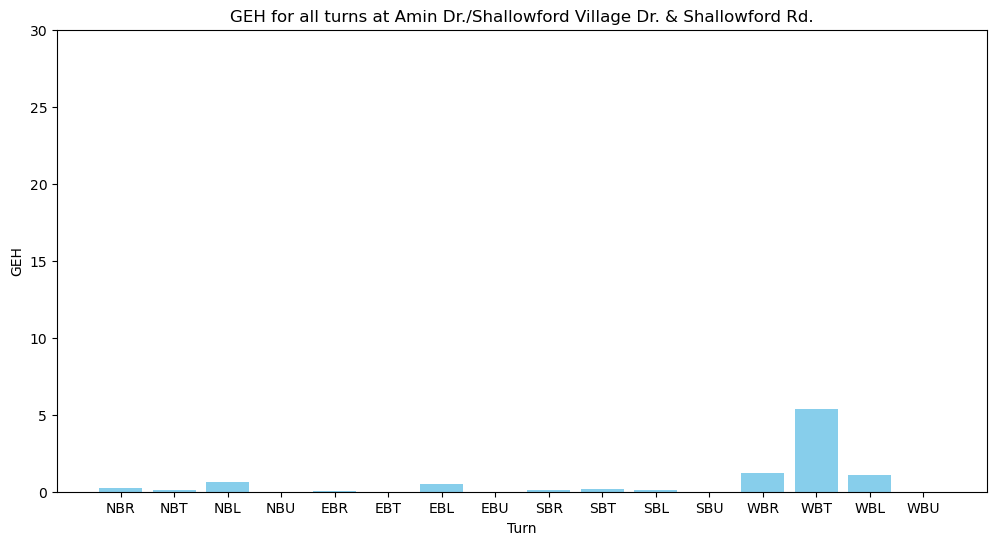

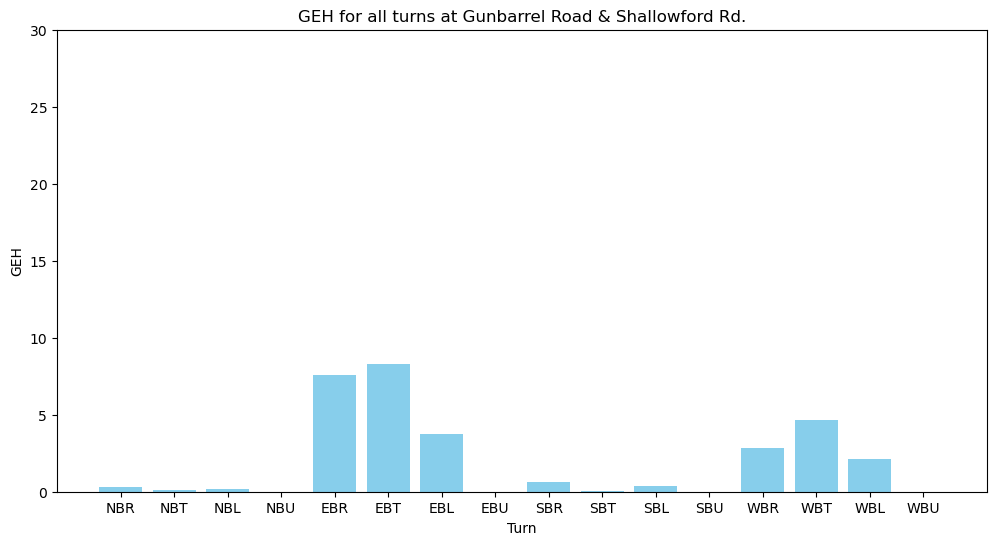

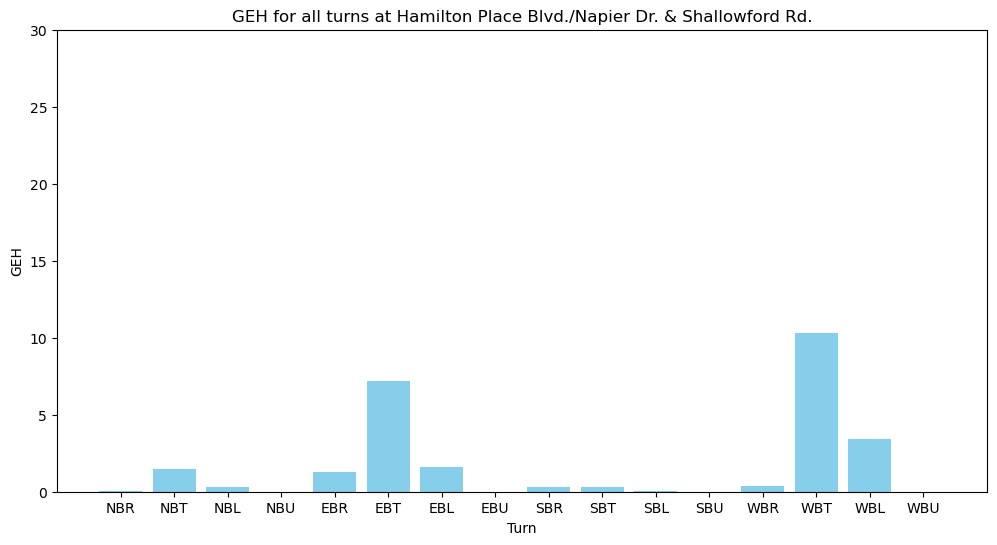

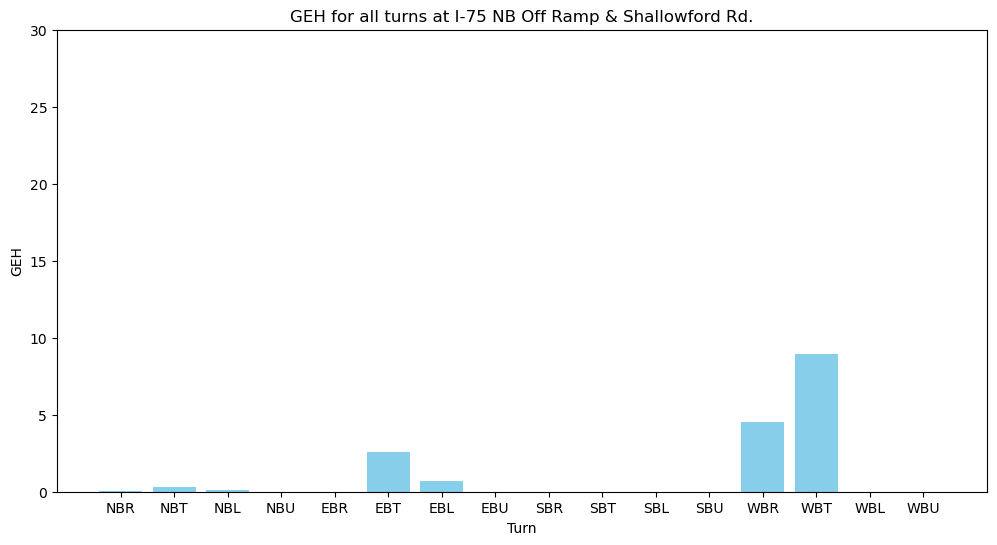

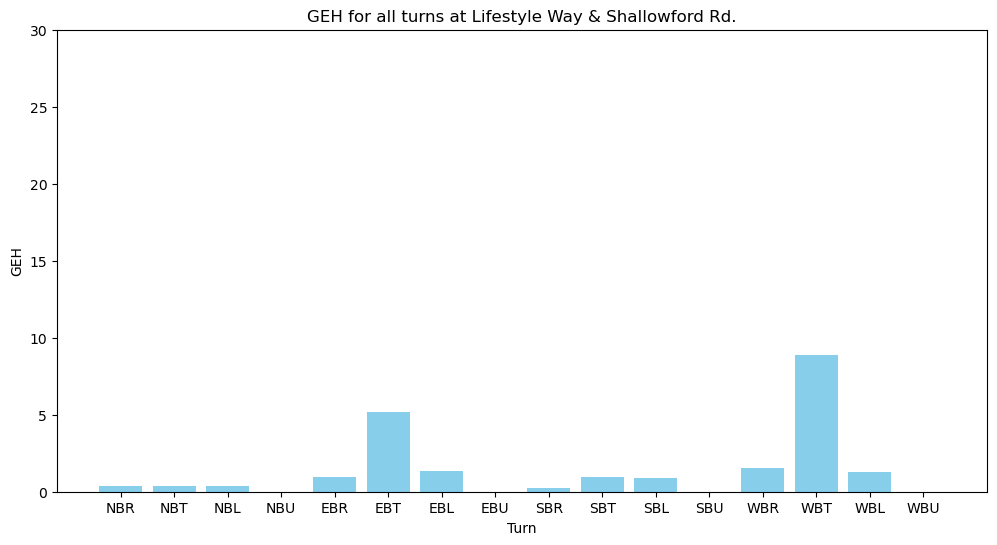

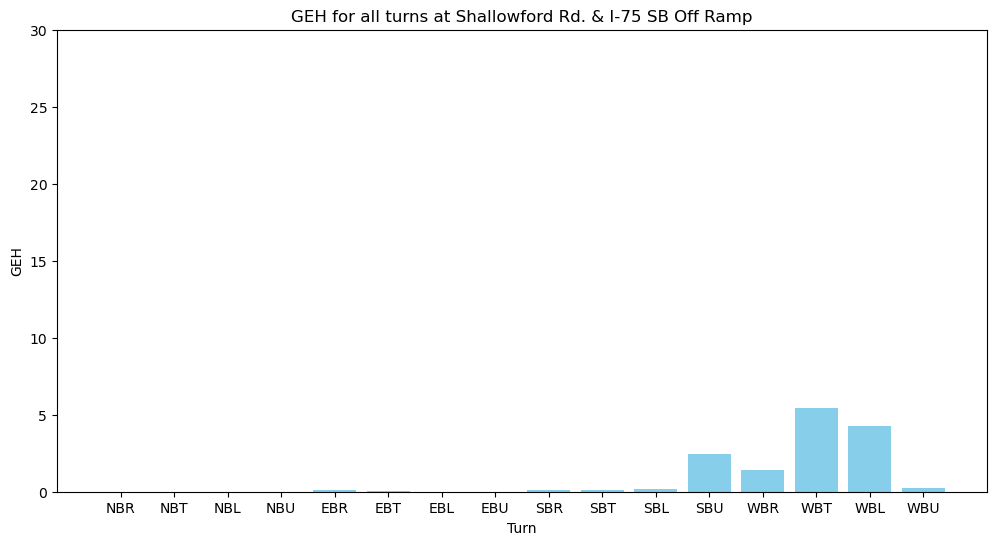

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the file into a DataFrame called summary
summary = pd.read_excel('summary_updated.xlsx')

# Define the desired sequence for the x-axis
turn_sequence = ['NBR', 'NBT', 'NBL', 'NBU', 'EBR', 'EBT', 'EBL', 'EBU',
                 'SBR', 'SBT', 'SBL', 'SBU', 'WBR', 'WBT', 'WBL', 'WBU']

for intersection, group in summary.groupby('IntersectionName'):
    plt.figure(figsize=(12, 6))
    sorted_group = group.set_index('Turn').reindex(turn_sequence).reset_index().fillna(0)
    plt.bar(sorted_group['Turn'], sorted_group['GEH'], color='skyblue')
    plt.xlabel('Turn')
    plt.ylabel('GEH')
    plt.ylim(0, 30)  # Set y-axis limits
    plt.title(f'GEH for all turns at {intersection}')
    plt.show()



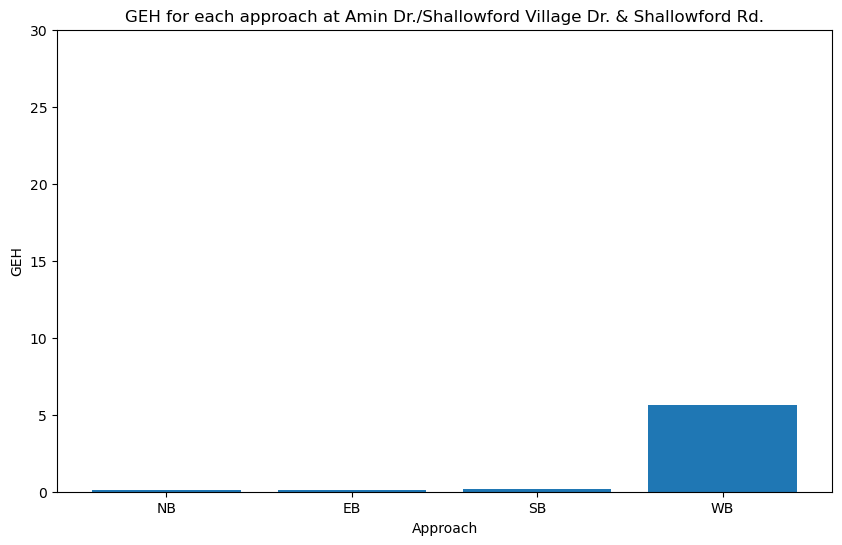

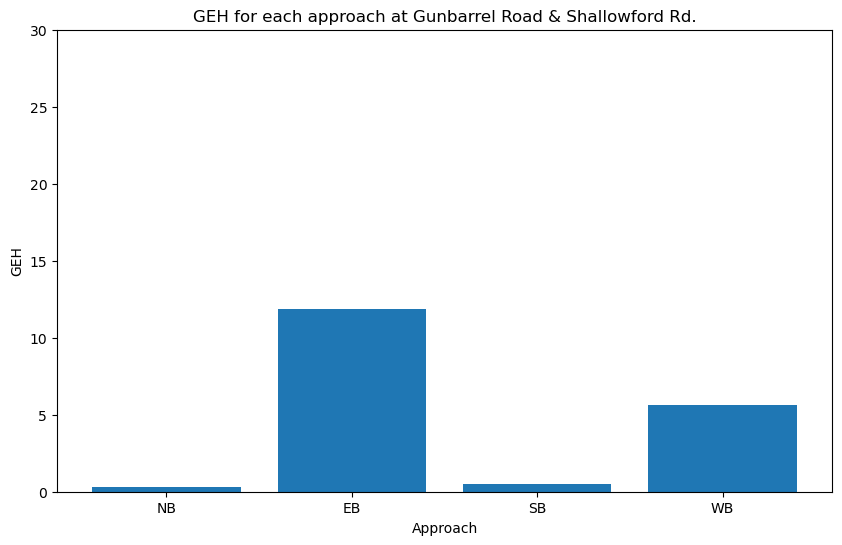

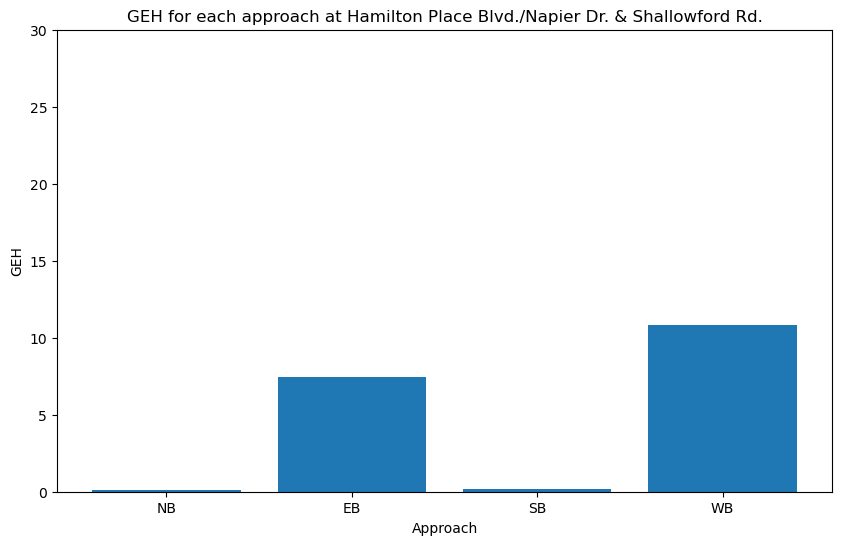

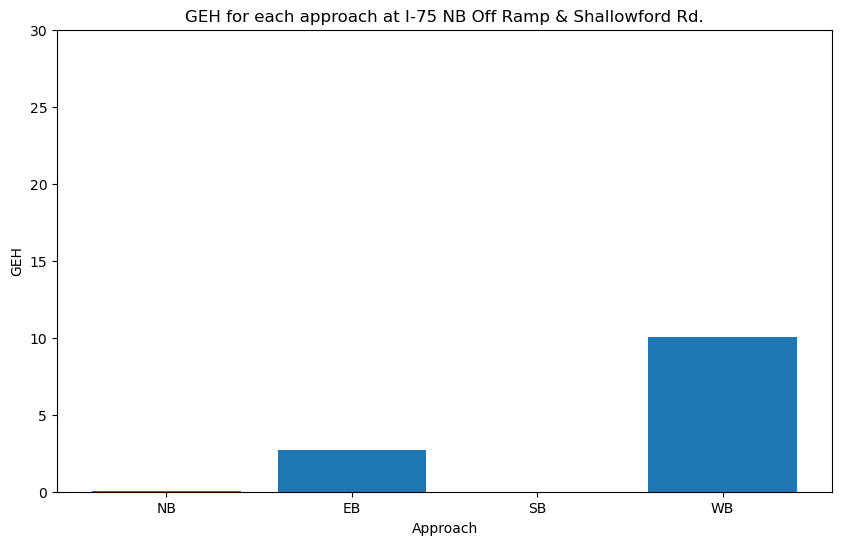

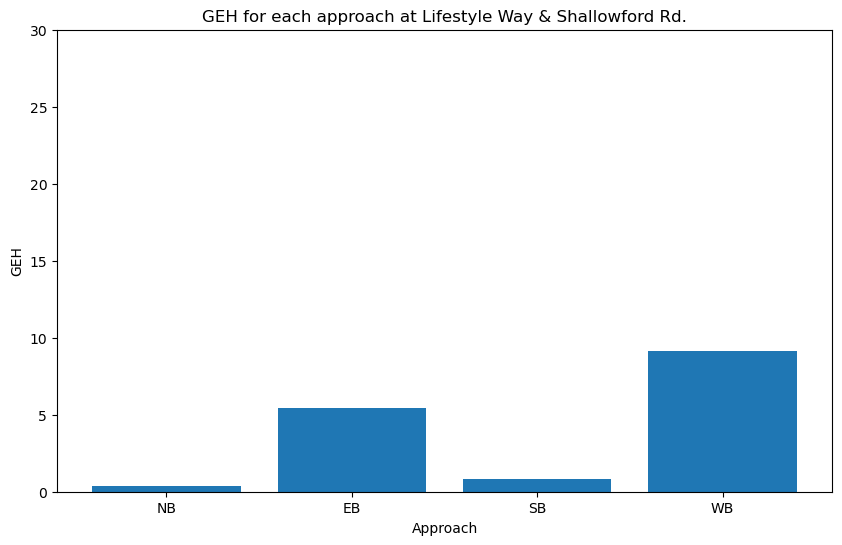

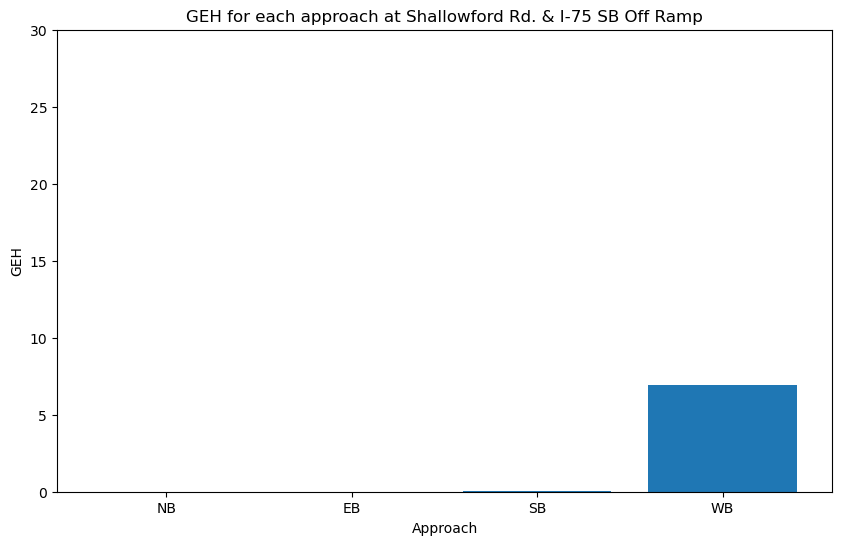

In [2]:
# Calculate the count and realcount for each approach within each intersection
summary['Bound'] = summary['Turn'].str[0] + summary['Turn'].str[1]
approach = summary.groupby(['IntersectionName', 'Bound']).agg({'count': 'sum', 'realcount': 'sum'}).reset_index()

import numpy as np
# Calculate GEH for each approach within each intersection
approach['GEH'] = np.sqrt(2 * (approach['count'] - approach['realcount'])**2 / (approach['count'] + approach['realcount']))

approach_sequence = ['NB','EB','SB','WB']
for intersection, group in approach.groupby('IntersectionName'):
    plt.figure(figsize=(10, 6))
    sorted_group = group.set_index('Bound').reindex(approach_sequence).reset_index().fillna(0)
    plt.bar(sorted_group['Bound'], sorted_group['GEH'])
    plt.xlabel('Approach')
    plt.ylabel('GEH')
    plt.title(f'GEH for each approach at {intersection}')
    plt.ylim(0, 30)  # Set y-axis limits
    plt.show()




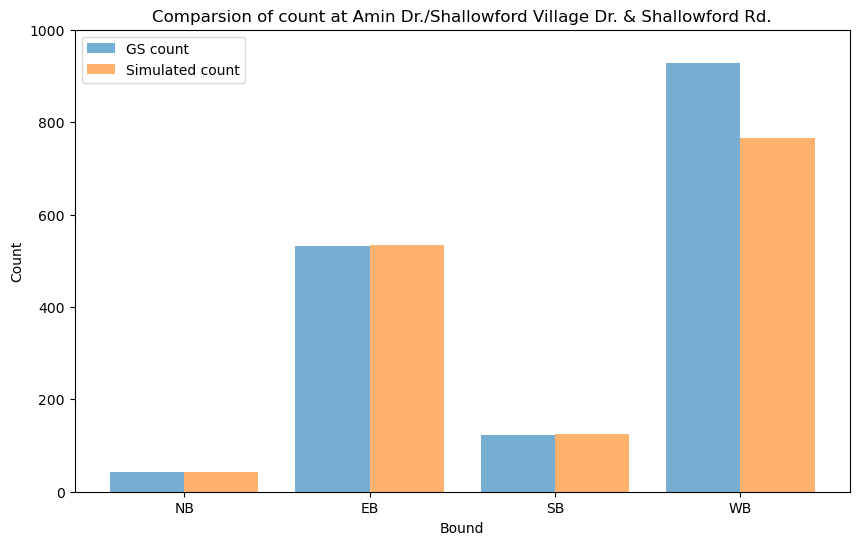

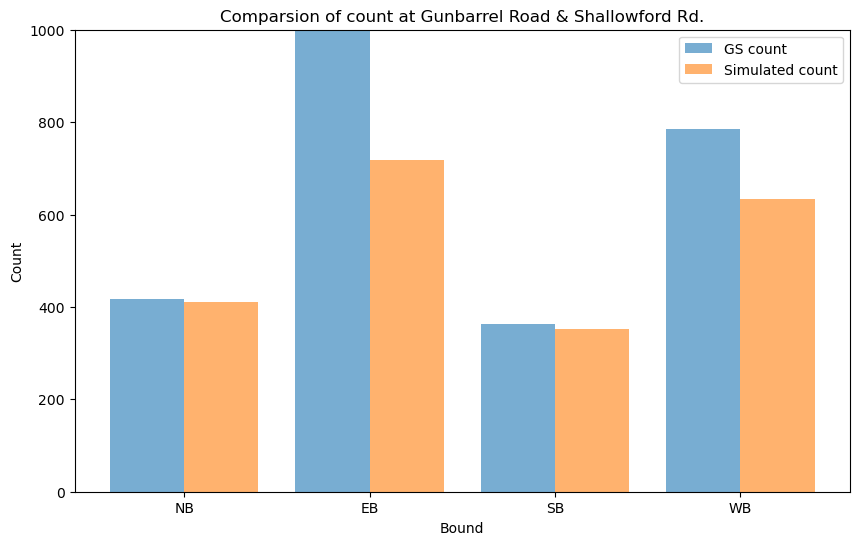

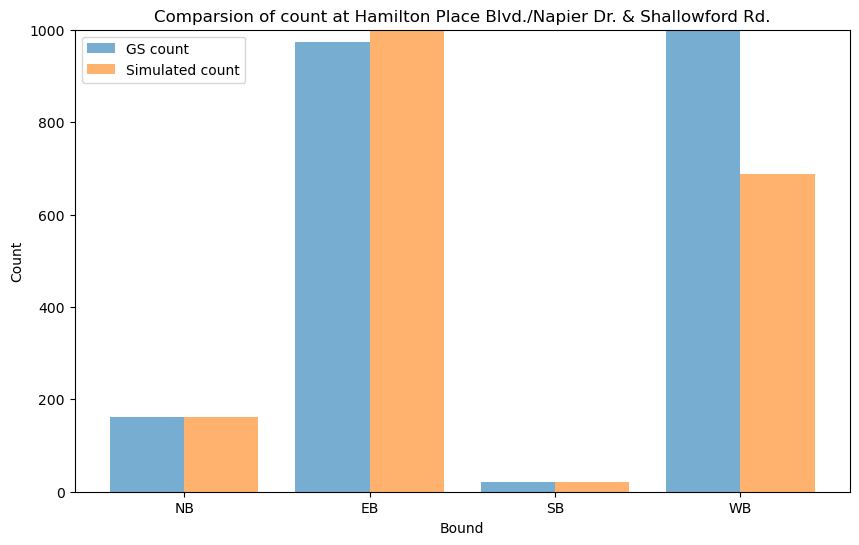

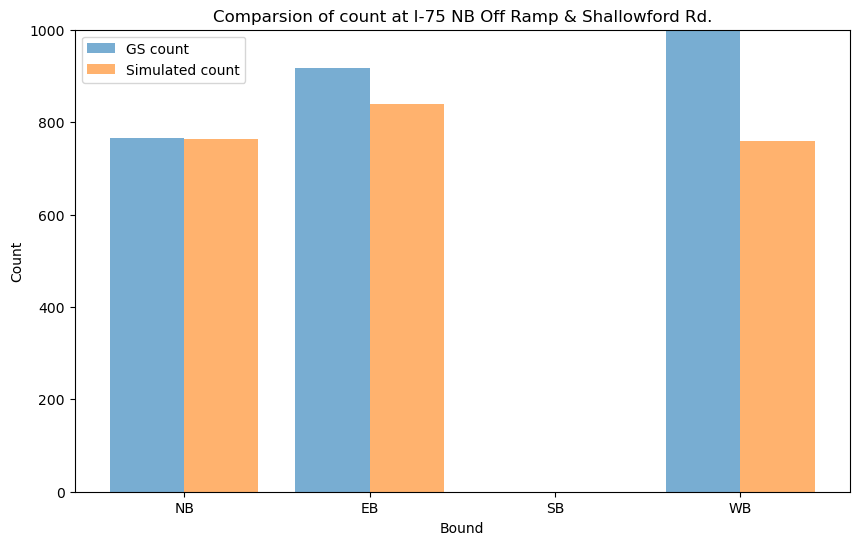

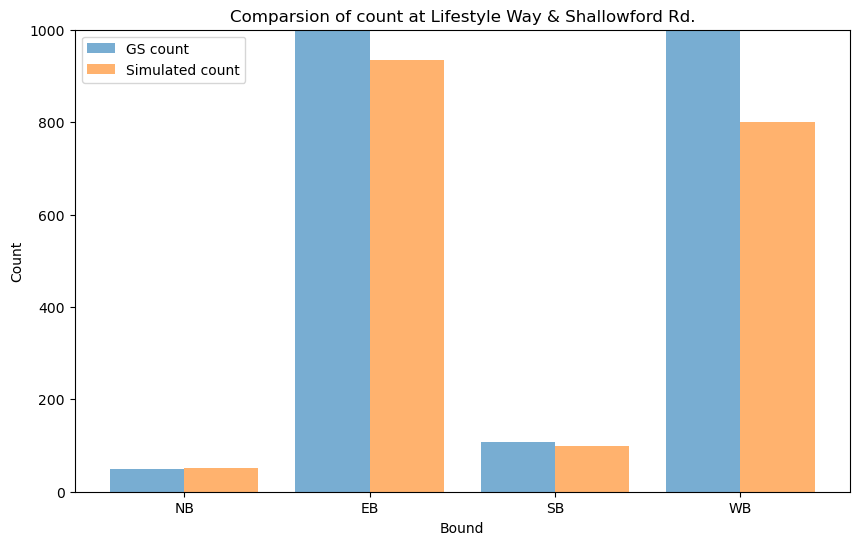

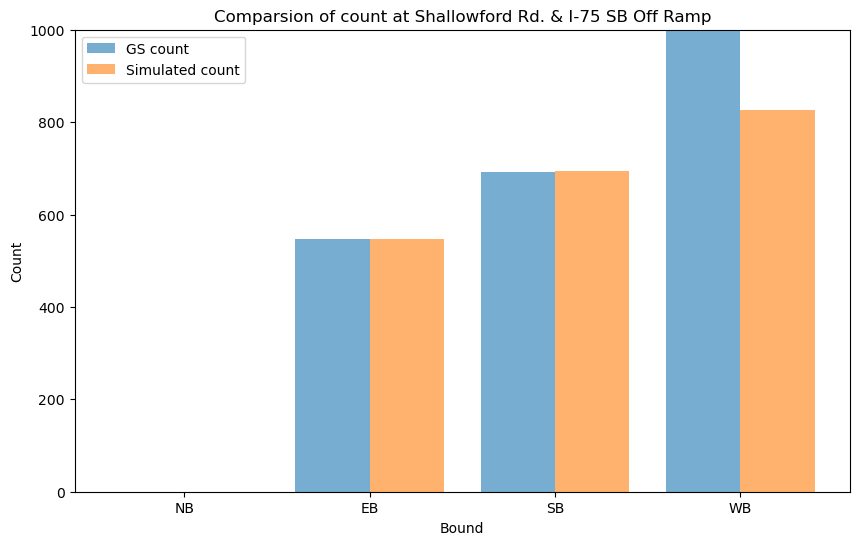

In [3]:
# Plot the realcount vs count for each approach in each intersection in a single figure, with specified colors
for intersection, group in approach.groupby('IntersectionName'):
    plt.figure(figsize=(10, 6))
    sorted_group = group.set_index('Bound').reindex(approach_sequence).reset_index()
    
    # Set the positions for the bars
    bar_width = 0.4
    positions_realcount = range(len(sorted_group))
    positions_count = [x + bar_width for x in positions_realcount]
    
    plt.bar(positions_realcount, sorted_group['realcount'], width=bar_width, label='GS count', alpha=0.6)
    plt.bar(positions_count, sorted_group['count'], width=bar_width, label='Simulated count', alpha=0.6)
    
    plt.xticks([p + bar_width / 2 for p in positions_realcount], sorted_group['Bound'])
    plt.xlabel('Bound')
    plt.ylabel('Count')
    plt.title(f'Comparsion of count at {intersection}')
    plt.legend()
    plt.ylim(0, 1000)  # Set y-axis limits
    plt.show()






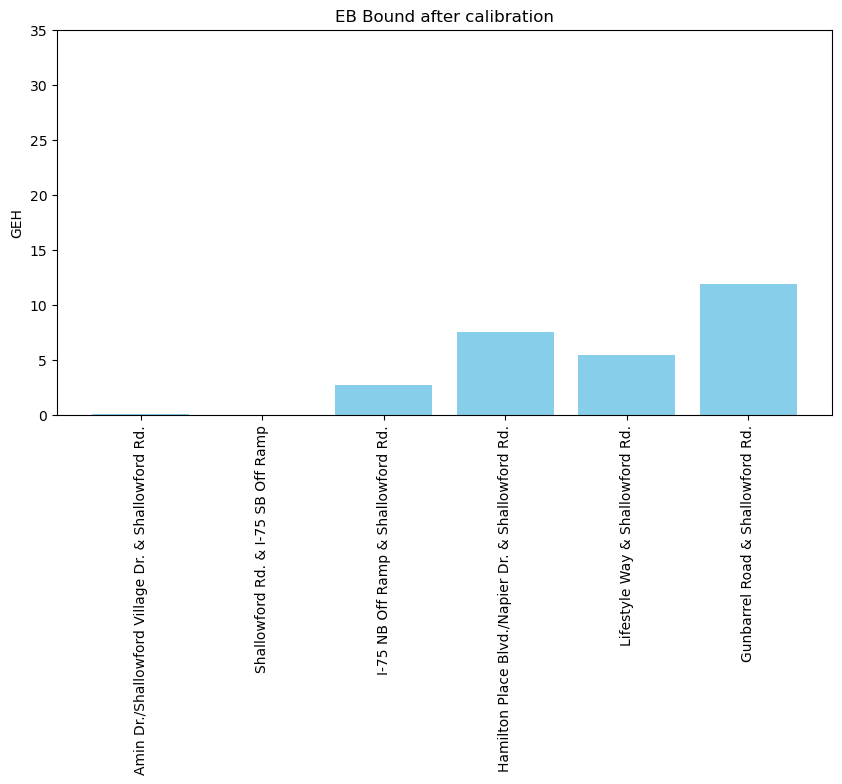

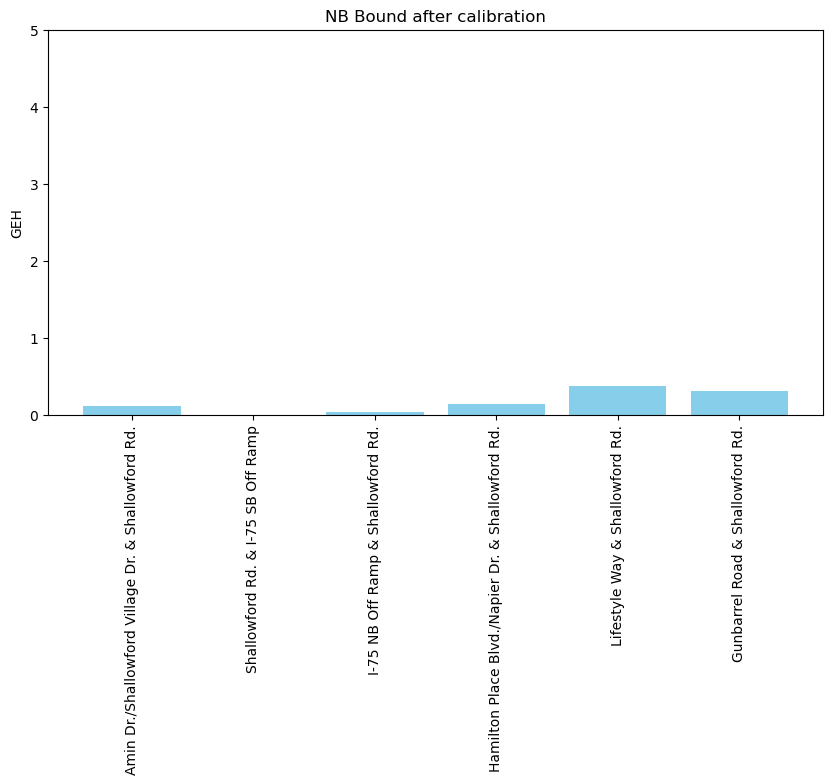

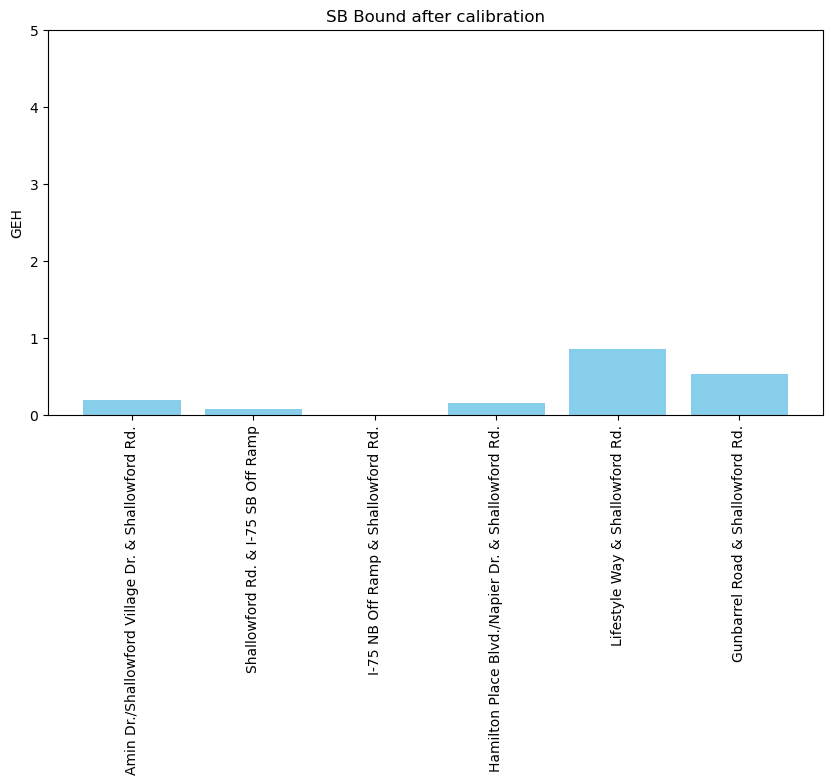

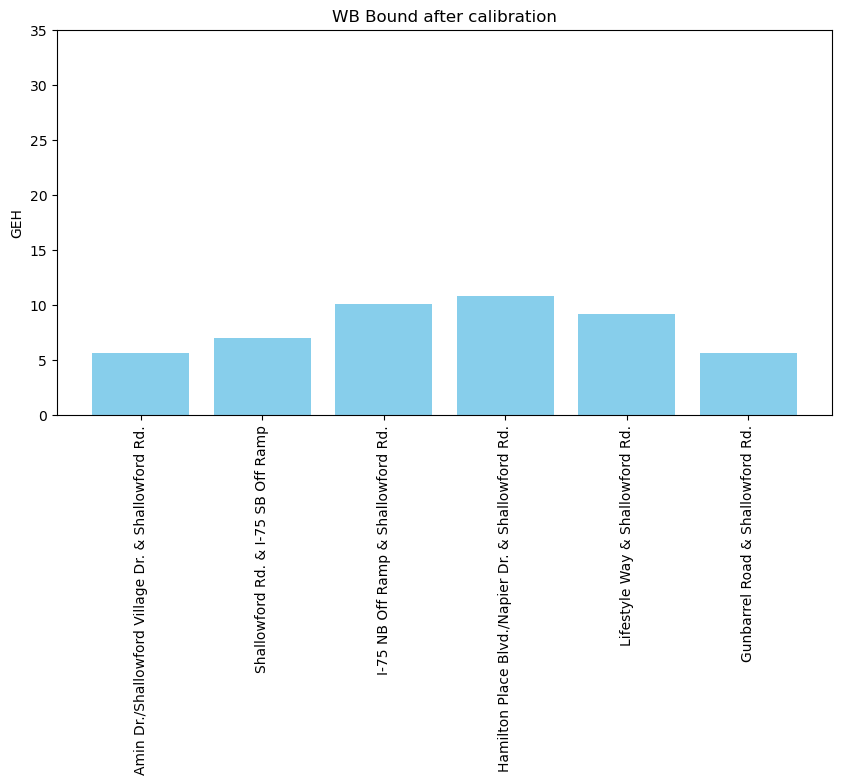

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the Excel file into a DataFrame
summary = pd.read_excel('summary_updated.xlsx')

# Create a new column 'Bound' by concatenating the first two characters of the 'Turn' column
summary['Bound'] = summary['Turn'].str[0] + summary['Turn'].str[1]

# Group by 'IntersectionName' and 'Bound', then aggregate the 'count' and 'realcount' columns
approach = summary.groupby(['IntersectionName', 'Bound']).agg({'count': 'sum', 'realcount': 'sum'}).reset_index()

# Calculate the GEH statistic
approach['GEH'] = np.sqrt(2 * (approach['count'] - approach['realcount'])**2 / (approach['count'] + approach['realcount']))

# Combine 'IntersectionName' and 'Bound' into a new column 'Intersection_Bound'
approach['Intersection_Bound'] = approach['IntersectionName'] + ' - ' + approach['Bound']

# Define the order of the intersections
intersection_order = [
    "Amin Dr./Shallowford Village Dr. & Shallowford Rd.",
    "Shallowford Rd. & I-75 SB Off Ramp",
    "I-75 NB Off Ramp & Shallowford Rd.",
    "Hamilton Place Blvd./Napier Dr. & Shallowford Rd.",
    "Lifestyle Way & Shallowford Rd.",
    "Gunbarrel Road & Shallowford Rd."
]

# Define the bounds
bounds = ['EB', 'NB', 'SB', 'WB']

# # Filter the DataFrame for each bound and plot the bar plots
# fig, axes = plt.subplots(1, 4, figsize=(20, 10), sharey=True)
# for i, bound in enumerate(bounds):
#     # Filter the DataFrame for the current bound
#     df_bound = approach[approach['Bound'] == bound]

#     # Reorder the DataFrame according to the predefined order
#     df_bound = df_bound.set_index('IntersectionName').loc[intersection_order].reset_index()

#     # Plot the bar plot
#     axes[i].bar(df_bound['Intersection_Bound'], df_bound['GEH'], color='skyblue')
#     axes[i].set_title(f'{bound} Bound')
#     axes[i].set_xticklabels(df_bound['Intersection_Bound'], rotation=90)

# # Set the y-axis label
# axes[0].set_ylabel('GEH')
# plt.ylim(0, 30)

# # Adjust the layout and show the plot
# plt.tight_layout()
# plt.show()

# Plot each bound in a separate figure
for bound in bounds:
    # Filter the DataFrame for the current bound
    df_bound = approach[approach['Bound'] == bound]

    # Reorder the DataFrame according to the predefined order
    df_bound = df_bound.set_index('IntersectionName').loc[intersection_order].reset_index()

    # Plot the bar plot
    plt.figure(figsize=(10, 5))
    plt.bar(df_bound['IntersectionName'], df_bound['GEH'], color='skyblue')
    plt.title(f'{bound} Bound after calibration')
    plt.xticks(rotation=90)
    plt.ylabel('GEH')
    if bound == 'EB':
        plt.ylim(0, 35)
    elif bound == 'NB':
        plt.ylim(0, 5)
    elif bound == 'WB':
        plt.ylim(0, 35)
    elif bound == 'SB':
        plt.ylim(0, 5)

    plt.show()




C:\Users\ggx\AppData\Local\Temp\1\ipykernel_32136\1009591335.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(df_bound['Intersection_Bound'], rotation=90,fontsize = 15)
C:\Users\ggx\AppData\Local\Temp\1\ipykernel_32136\1009591335.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(axes[i].get_yticks(),fontsize = 15)
C:\Users\ggx\AppData\Local\Temp\1\ipykernel_32136\1009591335.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(df_bound['Intersection_Bound'], rotation=90,fontsize = 15)
C:\Users\ggx\AppData\Local\Temp\1\ipykernel_32136\1009591335.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(axes[i].get_yticks(),fontsize = 15)
C:\Users\ggx\AppData\Local\Temp\1\ipykernel_32136\1009591335.py:45: UserWarning: FixedFormatter should only be used together with Fixe

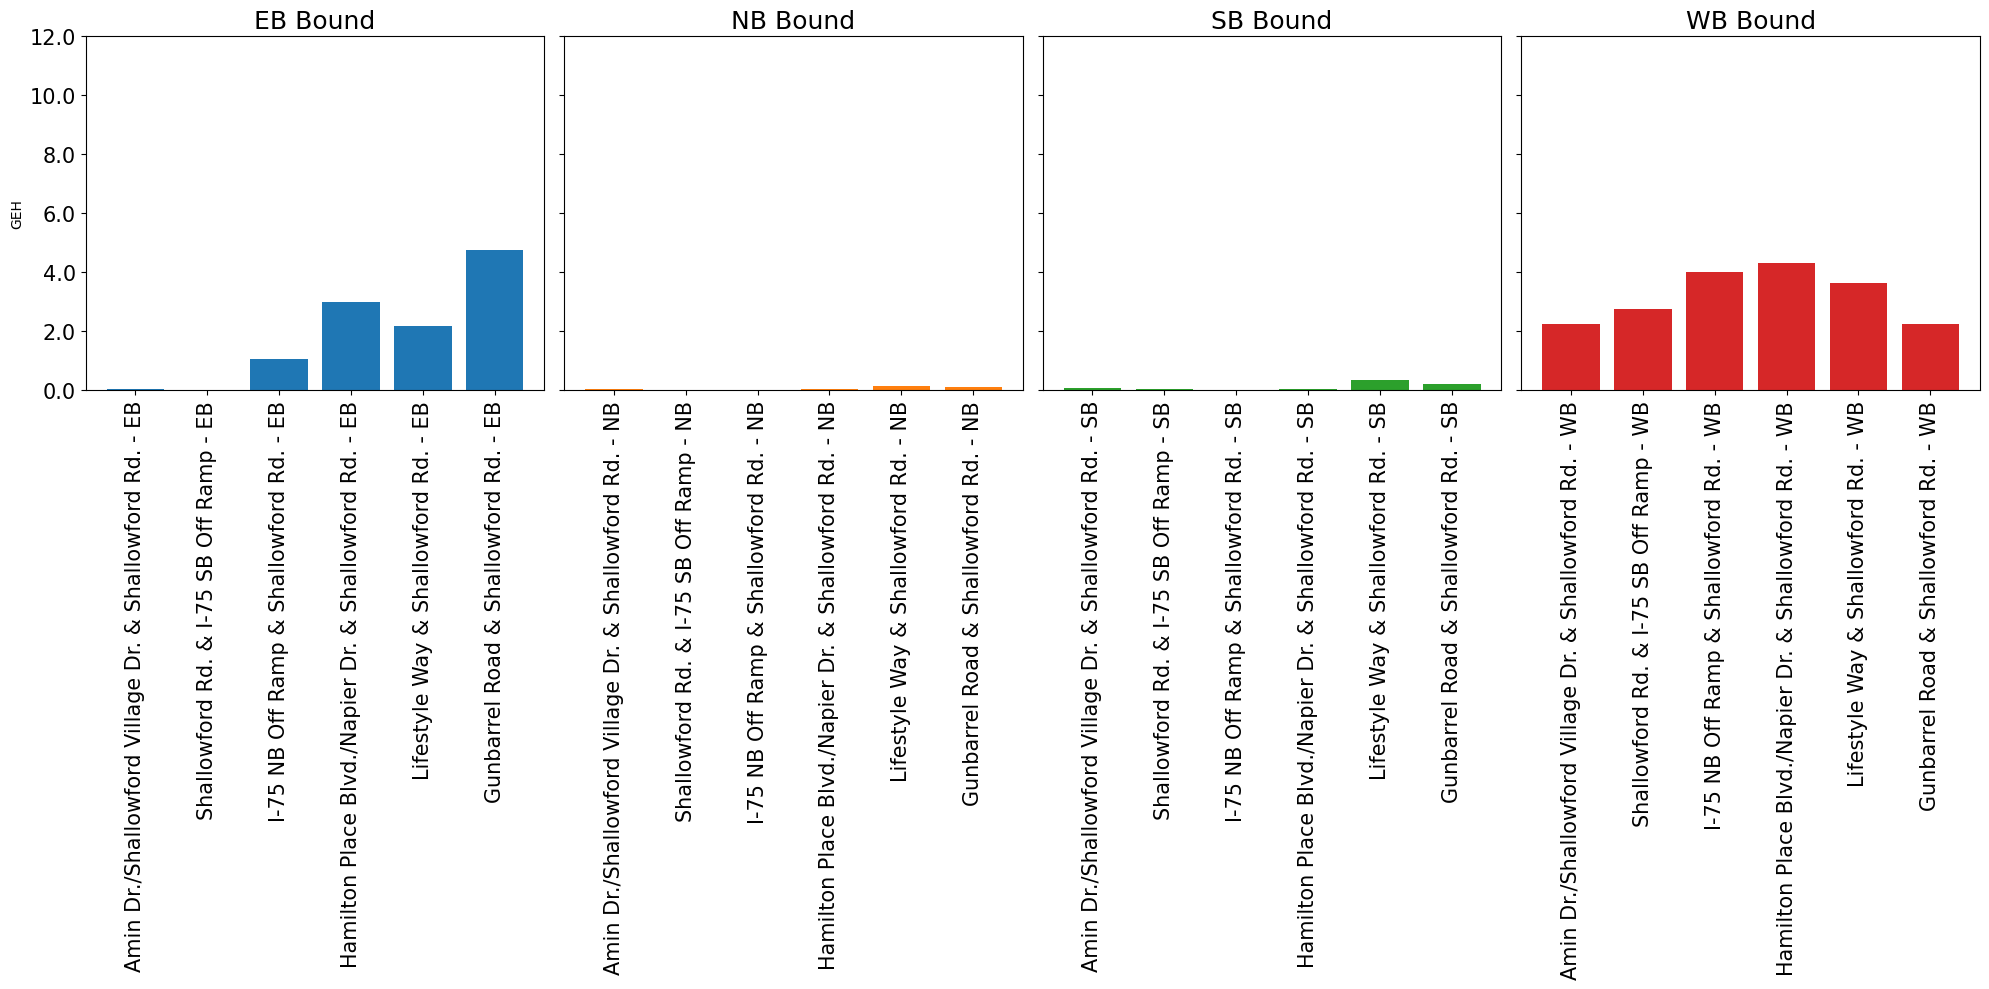

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the Excel file into a DataFrame
summary = pd.read_excel('summary_updated.xlsx')

# Create a new column 'Bound' by concatenating the first two characters of the 'Turn' column
summary['Bound'] = summary['Turn'].str[0] + summary['Turn'].str[1]

# Group by 'IntersectionName' and 'Bound', then aggregate the 'count' and 'realcount' columns
approach = summary.groupby(['IntersectionName', 'Bound']).agg({'count': 'sum', 'realcount': 'sum'}).reset_index()

# Calculate the GEH statistic
approach['GEH'] = np.sqrt(2 * (approach['count'] - approach['realcount'])**2 / (approach['count'] + approach['realcount']))

# Combine 'IntersectionName' and 'Bound' into a new column 'Intersection_Bound'
approach['Intersection_Bound'] = approach['IntersectionName'] + ' - ' + approach['Bound']

# Define the order of the intersections
intersection_order = [
    "Amin Dr./Shallowford Village Dr. & Shallowford Rd.",
    "Shallowford Rd. & I-75 SB Off Ramp",
    "I-75 NB Off Ramp & Shallowford Rd.",
    "Hamilton Place Blvd./Napier Dr. & Shallowford Rd.",
    "Lifestyle Way & Shallowford Rd.",
    "Gunbarrel Road & Shallowford Rd."
]

# Define the bounds
bounds = ['EB', 'NB', 'SB', 'WB']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
# Filter the DataFrame for each bound and plot the bar plots
fig, axes = plt.subplots(1, 4, figsize=(20, 10), sharey=True)
for i, bound in enumerate(bounds):
    # Filter the DataFrame for the current bound
    df_bound = approach[approach['Bound'] == bound]

    # Reorder the DataFrame according to the predefined order
    df_bound = df_bound.set_index('IntersectionName').loc[intersection_order].reset_index()

    # Plot the bar plot
    axes[i].bar(df_bound['Intersection_Bound'], df_bound['GEH'], color=colors[i])
    axes[i].set_title(f'{bound} Bound',fontsize = 18)
    axes[i].set_xticklabels(df_bound['Intersection_Bound'], rotation=90,fontsize = 15)
    axes[i].set_yticklabels(axes[i].get_yticks(),fontsize = 15)

# Set the y-axis label
axes[0].set_ylabel('GEH')
plt.ylim(0, 30)

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()